In [9]:
import random
import numpy as np

import torch
import torch.nn as nn

import scipy

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
from torchvision.models import resnet50

from tqdm.notebook import tqdm, trange

# Фиксируем random seed для воспроизводимости результатов
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


OUTPUT_DIM = 10  # Количество классов
EPOCH_NUM = 4  # Сколько эпох будет обучать модель

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
basic_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])  # Базовые аугментации для тренировочных данных (грубо говоря бесплатное увеличение тренировочной выборки)

In [11]:
# Загрузим данные

train_dataset = SVHN(
    root='./data/svhn/train',
    split='train', 
    transform=basic_transform,
    download=False
)

test_dataset = SVHN(
    root='./data/svhn/test',
    split='test', 
    transform=transforms.ToTensor(),  # Для тестовых данные НЕ НАДО использовать никакие аугментации
    download=False
)

In [12]:
# Создадим DataLoader'ы (для того чтобы было проще итерироваться)

dataloaders = {
    'train': DataLoader(
        dataset=train_dataset,
        batch_size=128, 
        shuffle=True
    ),
    'val': DataLoader(
        dataset=test_dataset,
        batch_size=128, 
        shuffle=False
    )
}

In [13]:
class SVHNClassifier(nn.Module):
    def __init__(self, ouput_dim):
        super(SVHNClassifier, self).__init__()  # "Регистрируем" создаваемый объект как нейросетевую модель
        self.model = resnet50(pretrained=True)  # Скачиваем пред-обученную основу для нашей модели
        
        # "Замораживаем" все веса для ускорения обучения (мы считаем что они уже хорошо обучены)
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Создаем "голову" которую мы и будем обучать
        self.fc1 = nn.Sequential(
            nn.Linear(1000, 64),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(64, ouput_dim)
        )
    
    def embed(self, x):
        return self.fc1(self.model(x))
    
    # Описываем как именно наша модель будет генерировать предсказания
    def forward(self, x):
        resnet_out = self.embed(x)
        return self.fc2(resnet_out)

In [14]:
model = SVHNClassifier(OUTPUT_DIM)
model = model.to(DEVICE)  # Переносим модель на GPU

In [15]:
# Создаем функцию ошибки (так как задача многоклассовой классификации, то используем кросс-энтропию)
loss_function = torch.nn.CrossEntropyLoss()

# Регистрируем для нашей модели способ изменения её весов
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)

In [16]:
loss_hist = {'train': [], 'val': []}
acc_hist = {'train': [], 'val': []}

# Основной алгоритм обучения
for epoch in trange(EPOCH_NUM, desc='Whole pipeline'):
    
    for phase in ['train', 'val']:
        dataloader = dataloaders[phase]
        
        # Это условие необходимо так как у нас есть слой DropOut
        # И на валидации его принято фиксировать
        if phase == 'train':
            model.train() 
        elif phase == 'val':
            model.eval()
        
        running_loss = 0.
        running_acc = 0.
        
        # Проходимся по набору данных
        for (X_batch, y_batch) in tqdm(dataloader, desc=f'Epoch: {epoch + 1}. Phase: {phase}'):
            # Нормализуем наши данные
            X_batch = X_batch / 255
            X_batch = transforms.Normalize((0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614))(X_batch)
            
            # Переносим на устройство
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            # Для корректного обучения перед каждым шагом необходимо сбрасывать прошлые ошибки
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)
                
                loss_value = loss_function(y_pred, y_batch)
                y_pred_class = y_pred.argmax(dim=1)
                
                # На обучении мы хотим учиться в зависимости от ошибки
                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()
                   
            # Аггрегируем ошибку и точность
            running_loss += loss_value.item()
            running_acc += (y_pred_class == y_batch.data).float().mean().data.cpu().numpy()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)
        
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ', end='')
        
        loss_hist[phase].append(epoch_loss)
        acc_hist[phase].append(epoch_acc)

Whole pipeline:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2819 Acc: 0.1720 

Epoch: 1. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2262 Acc: 0.2005 

Epoch: 2. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2408 Acc: 0.1894 

Epoch: 2. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2135 Acc: 0.2064 

Epoch: 3. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2323 Acc: 0.1939 

Epoch: 3. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2051 Acc: 0.2094 

Epoch: 4. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2274 Acc: 0.1941 

Epoch: 4. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2039 Acc: 0.2143 

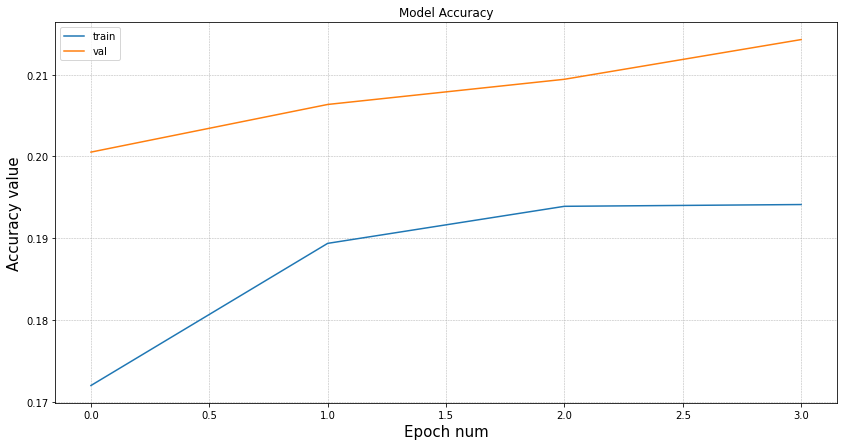

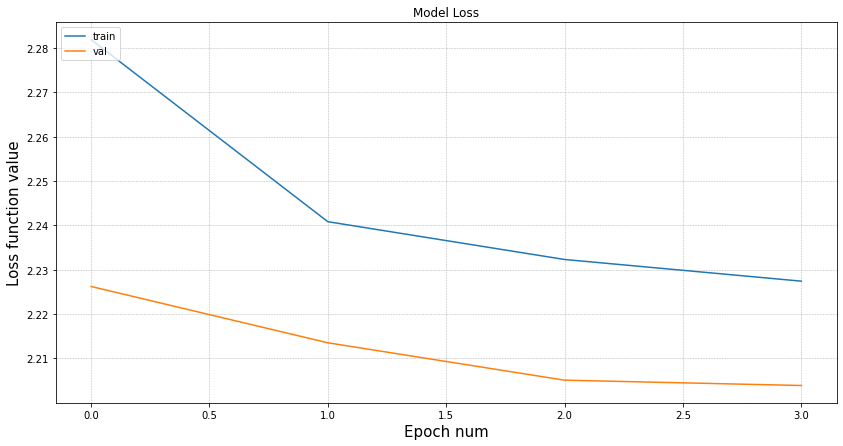

In [17]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

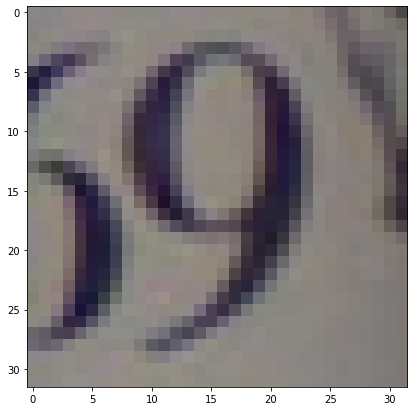

In [18]:
img_50 = test_dataset[50][0].detach().numpy()

plt.imshow(np.transpose(img_50, (1,2,0)))

In [28]:
test_items = [test_dataset[i] for i in range(1000)]
xs, ys = zip(*test_items)

xs = torch.stack(xs)
xs = transforms.Normalize((0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614))(xs)
xs.size()

torch.Size([1000, 3, 32, 32])

In [29]:
embs = model.embed(xs)
embs.size()

torch.Size([1000, 64])

In [30]:
import umap

points = umap.UMAP().fit_transform(embs.detach().numpy())
points.shape

(1000, 2)

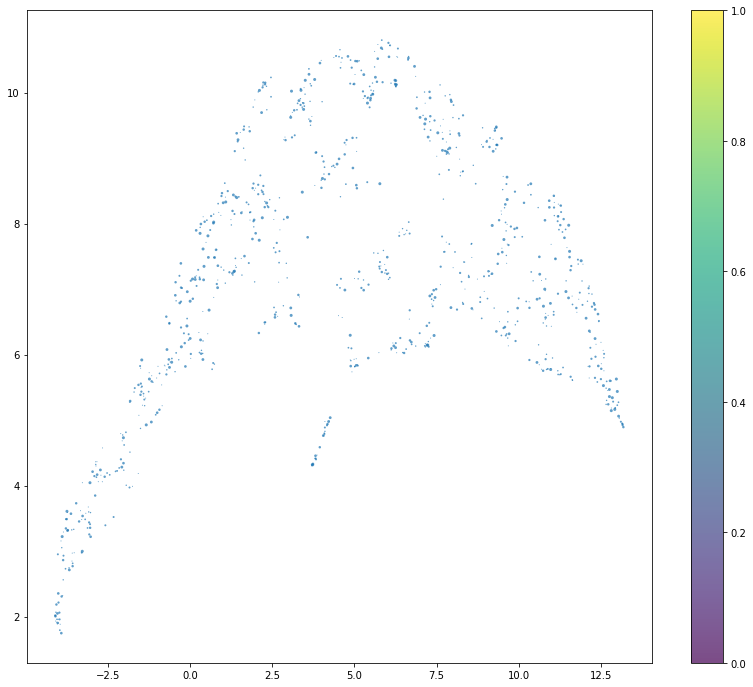

In [31]:
plt.figure(figsize=(14,12))
plt.scatter(points[:, 0], points[:, 1],
            edgecolor='none', alpha=0.7, s=ys,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

In [32]:
from tensorboardX import SummaryWriter

# log embeddings
writer = SummaryWriter()
writer.add_embedding(embs,
                     metadata=ys,
                     label_img=xs.detach().numpy())
writer.close()